<H1><center>Analyses Statistiques</center></H1>

In [ ]:
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from scipy.stats import mannwhitneyu, kruskal
import numpy as np

In [7]:
df = pd.read_csv("train.csv")

In [9]:
df = df.drop(
    [
        "ID",
        "Customer_ID",
        "Name",
        "Credit_Mix",
        "SSN",
        "Type_of_Loan",
        "Payment_of_Min_Amount",
    ],
    axis=1,
)

## Analyses Bivariées

Certains tests statistiques seront exclus dans notre étude comme le test de Pearson dans les analyses de corrélation, le test de Student (t-test) et le test ANOVA dans les analyses d'association. En effet, il a été demontré précédemment avec le test de Shapiro que toutes les variables quantitatives concernées ne sont pas normalement distribuées.

On se tournera donc vers d'autres tests:

- les tests de corrélation de Spearman et de Kendall
- le test de Mann-Whitney (scam a deux modalités)
- le test de Chi-carré, et le coefficient de Cramer-V

### 1.Variable cible 

#### 1.A.Variables quantitatives & variables catégorielles sous format numérique

##### Corrélation Spearman & Kendall

/tmp/ipykernel_260199/2400332787.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Credit_Score_Num']=df['Credit_Score'].replace({'Poor': 0, 'Standard':1, 'Good': 2})


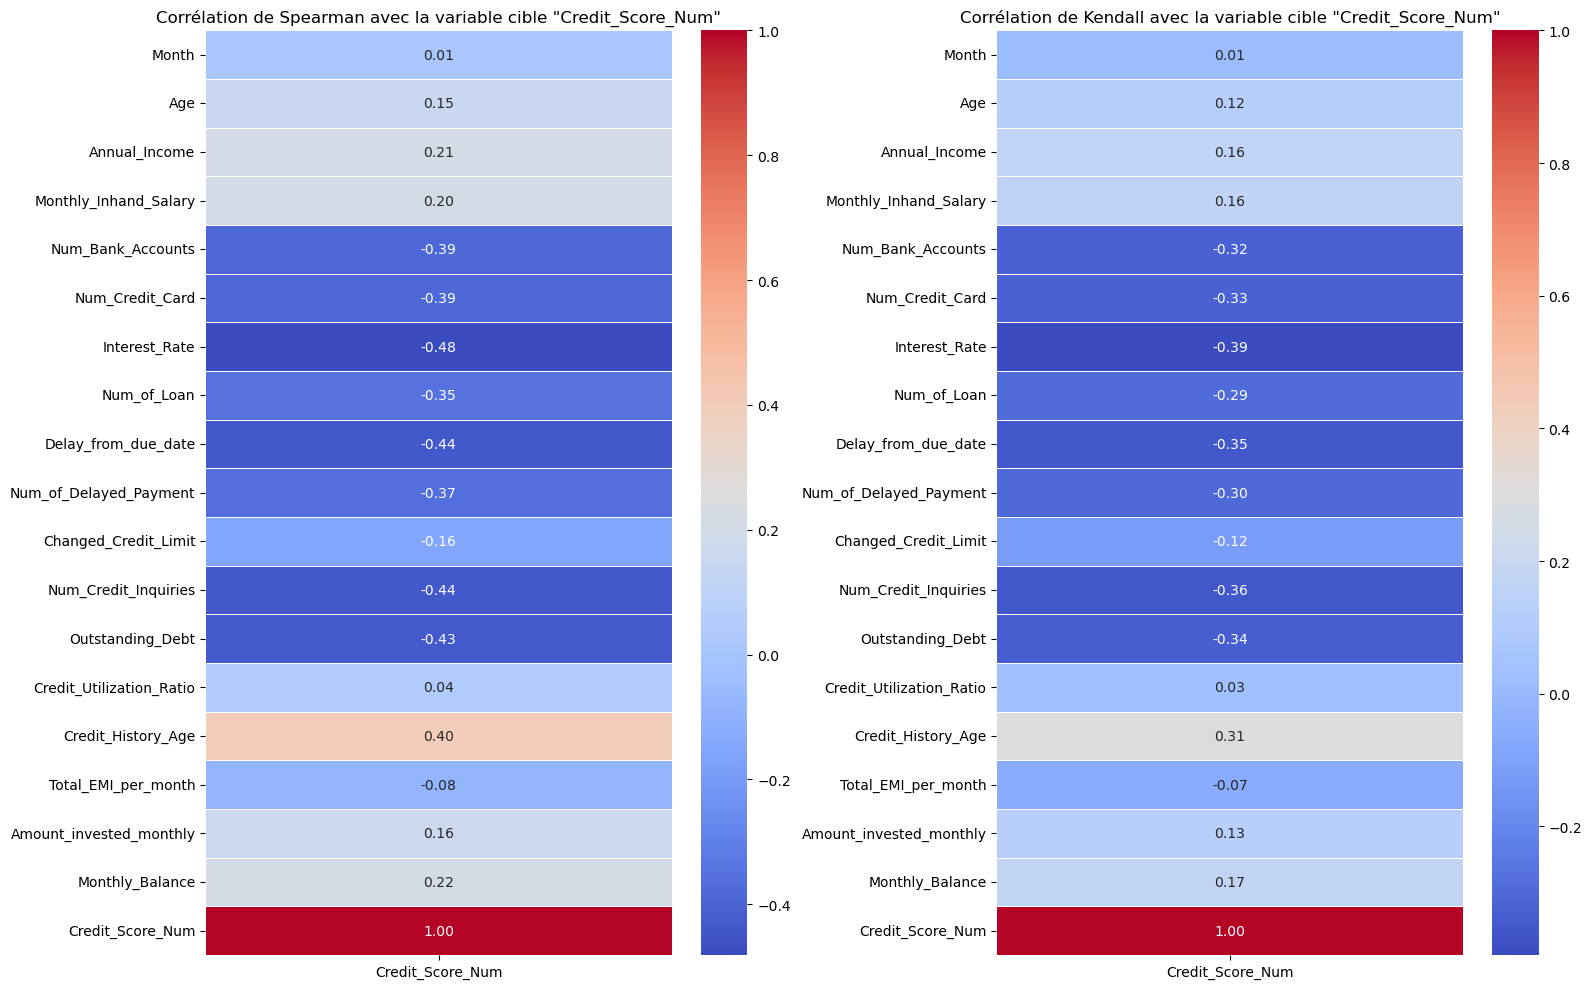

In [10]:
df["Credit_Score_Num"] = df["Credit_Score"].replace(
    {"Poor": 0, "Standard": 1, "Good": 2}
)
numeric_columns = df.select_dtypes(include="number")

correlation_matrix_spearman, _ = spearmanr(numeric_columns)
correlation_scam = correlation_matrix_spearman[
    numeric_columns.columns == "Credit_Score_Num"
]


correlation_matrix_kendall = numeric_columns.corr(method="kendall")
correlation_scam_kendall = correlation_matrix_kendall.loc[["Credit_Score_Num"]]


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

sns.heatmap(
    correlation_scam.T,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5,
    fmt=".2f",
    xticklabels=["Credit_Score_Num"],
    yticklabels=numeric_columns.columns,
    ax=axes[0],
)
axes[0].set_title('Corrélation de Spearman avec la variable cible "Credit_Score_Num"')


sns.heatmap(
    correlation_scam_kendall.T,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5,
    fmt=".2f",
    xticklabels=["Credit_Score_Num"],
    yticklabels=numeric_columns.columns,
    ax=axes[1],
)
axes[1].set_title('Corrélation de Kendall avec la variable cible "Credit_Score_Num"')
plt.tight_layout()
plt.show()

On retrouve des liens forts entre la variable cible et les variables Interest_Rate, Num_credit_Inquiries, Delay_from_due_date ou encore Credit_History_Age:

- Interest_Rate :

En général, un taux d'intérêt plus élevé sur une carte de crédit est souvent associé à un risque plus élevé pour l'émetteur de la carte. Cela signifie que les détenteurs de cartes avec un historique de crédit moins favorable ou une capacité à rembourser moins certaine peuvent se voir attribuer des taux d'intérêt plus élevés. Ce coefficient de -0.48 reflète cette tendance : plus le taux est élevé, plus la variable cible a une valeur petit, indiquant un client risqué de la catégorie Poor. À l'inverse, des taux moins élevés sont associés à la variable cible ayant la valeur 2, indiquant un client Good.

- Num_credit_Inquiries :

Une corrélation significative a été observée entre la variable cible et le nombre de fois qu'une personne a fait une demande pour obtenir une nouvelle carte de crédit ou un nouveau crédit. En général, plus le client fait de demandes de pret moins il est fiable et moins il a de revenus pour se financer lui-même d'où ce coefficient négatif.

- Delay_from_due_date :

Une corrélation a été identifiée entre la variable cible et le nombre moyen de jours de retard par la personne à compter de la date de paiement. Ce coefficiant à -0.4 signifie que, en général, les demandes de prêt de meilleure qualité (comme indiqué par des scores plus élevés) sont associées à un nombre plus faible de jours de retard dans les paiements, et vice versa. En d'autres termes, les emprunteurs qui ont un historique de retards de paiement plus élevé ont tendance à être associés à des demandes de prêt de qualité inférieure.

- Credit_History_Age :

La corrélation entre la variable cible et l'âge des antécédents de crédit de la personne est également notable. L'âge des antécédents de crédit est un facteur important pour évaluer la solvabilité d'un individu. Une longue histoire de crédit peut indiquer une gestion financière responsable et une capacité à gérer les dettes sur le long terme. Cela peut être considéré comme un indicateur positif par les prêteurs, car cela suggère une probabilité plus élevée de remboursement en temps voulu. Ainsi, on peut expliquer ce coefficient positif, si la variable cible est élevée à 2 (Good) alors que Credit_History_Age également.

En outre, bon nombre des principes mentionnés peuvent également être appliqués à d'autres variables qui opèrent de manière similaire, telles que Num_Credit_Card, Num_Bank_accounts,Num_Delayed_Payment.

#### 1.B.Variables catégorielles

##### Occupation

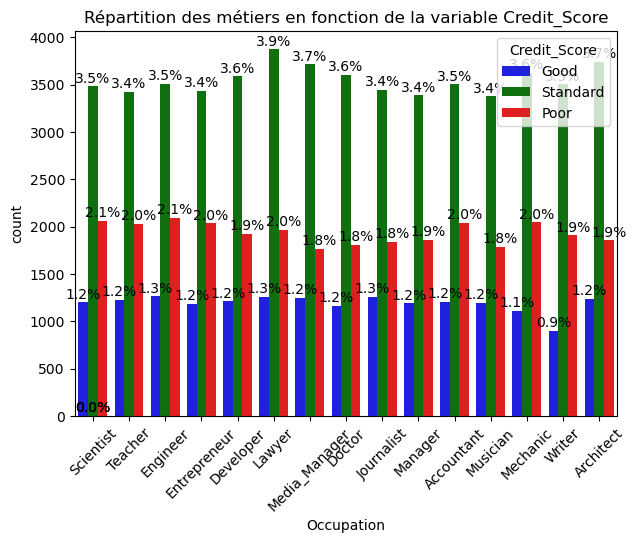

In [14]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(
    x="Occupation",
    data=df,
    hue="Credit_Score",
    palette={"Poor": "red", "Standard": "green", "Good": "blue"},
    legend=True,
    dodge=True,
)
plt.title("Répartition des métiers en fonction de la variable Credit_Score")

total = len(df["Occupation"])
for p in ax.patches:
    percentage = f"{100*p.get_height()/total:.1f}%\n"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha="center", va="center")

plt.xticks(rotation=45)
plt.show()

In [15]:
ct = pd.crosstab(df["Occupation"], df["Credit_Score"])
chi2_stat, p_value, dof, expected_freq = chi2_contingency(ct)

print("Statistique du test de chi-carré :", chi2_stat)
print("p_value :", p_value)
print("Degrés de liberté :", dof)

Statistique du test de chi-carré : 180.68588839512742
p_value : 2.907103747503745e-24
Degrés de liberté : 28


La P-value est inférieure à 0.05 : il y a une association entre les deux variables.

Par contre, il faut calculer le coefficient de Cramer-V pour mesurer la force d'association.

In [16]:
# Coefficient de Cramer-V
n = ct.sum().sum()
min_dim = min(ct.shape) - 1
cramer_v = np.sqrt(chi2_stat / (n * min_dim))

# Afficher du résultat
print("Coefficient de Cramer-V :", cramer_v.round(3))

Coefficient de Cramer-V : 0.03


La valeur de Cramer-V est de 0.03, il s'agit d'une association faible entre les deux variables.

En effet, la répartition des métiers pour la variable cible semble assez équilibré ce qui peut expliquer cette faible association.

##### Payment_Behaviour

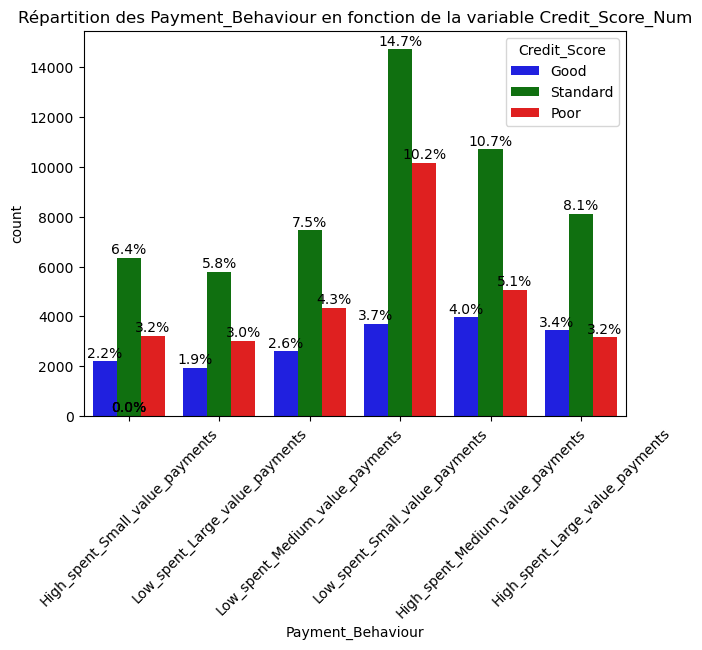

In [17]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(
    x="Payment_Behaviour",
    data=df,
    hue="Credit_Score",
    palette={"Poor": "red", "Standard": "green", "Good": "blue"},
    legend=True,
    dodge=True,
)
plt.title(
    "Répartition des Payment_Behaviour en fonction de la variable Credit_Score_Num"
)

total = len(df["Payment_Behaviour"])
for p in ax.patches:
    percentage = f"{100*p.get_height()/total:.1f}%\n"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha="center", va="center")

plt.xticks(rotation=45)
plt.show()

In [18]:
ct = pd.crosstab(df["Payment_Behaviour"], df["Credit_Score"])
chi2_stat, p_value, dof, expected_freq = chi2_contingency(ct)

print("Statistique du test de chi-carré :", chi2_stat)
print("p_value :", p_value)
print("Degrés de liberté :", dof)

Statistique du test de chi-carré : 1540.3973697187996
p_value : 0.0
Degrés de liberté : 10


In [19]:
# Coefficient de Cramer-V
n = ct.sum().sum()
min_dim = min(ct.shape) - 1
cramer_v = np.sqrt(chi2_stat / (n * min_dim))

# Afficher du résultat
print("Coefficient de Cramer-V :", cramer_v.round(3))

Coefficient de Cramer-V : 0.088


La valeur de Cramer-V est inférieure à 0.6
L'association entre les deux variables est faible.

##### Country

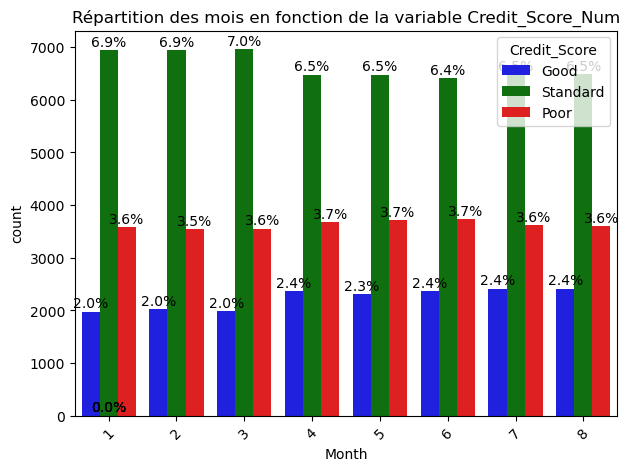

In [20]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(
    x="Month",
    data=df,
    hue="Credit_Score",
    palette={"Poor": "red", "Standard": "green", "Good": "blue"},
    legend=True,
    dodge=True,
)
plt.title("Répartition des mois en fonction de la variable Credit_Score_Num")

total = len(df["Month"])
for p in ax.patches:
    percentage = f"{100*p.get_height()/total:.1f}%\n"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha="center", va="center")

plt.xticks(rotation=45)
plt.show()

In [21]:
ct = pd.crosstab(df["Month"], df["Credit_Score"])
chi2_stat, p_value, dof, expected_freq = chi2_contingency(ct)

print("Statistique du test de chi-carré :", chi2_stat)
print("p_value :", p_value)
print("Degrés de liberté :", dof)

Statistique du test de chi-carré : 201.80530639299857
p_value : 2.349409913674008e-35
Degrés de liberté : 14


La P-value est inférieure à 0.05 : il y a une association entre les deux variables.

Par contre, il faut calculer le coefficient de Cramer-V pour mesurer la force d'association.

In [22]:
# Coefficient de Cramer-V
n = ct.sum().sum()
min_dim = min(ct.shape) - 1
cramer_v = np.sqrt(chi2_stat / (n * min_dim))

# Afficher du résultat
print("Coefficient de Cramer-V :", cramer_v.round(3))

Coefficient de Cramer-V : 0.032


La valeur de Cramer-V est inférieure à 0.032
L'association entre les deux variables est faible.

### 2.Variables Explicatives

#### Matrices de Spearman & Kendall globales

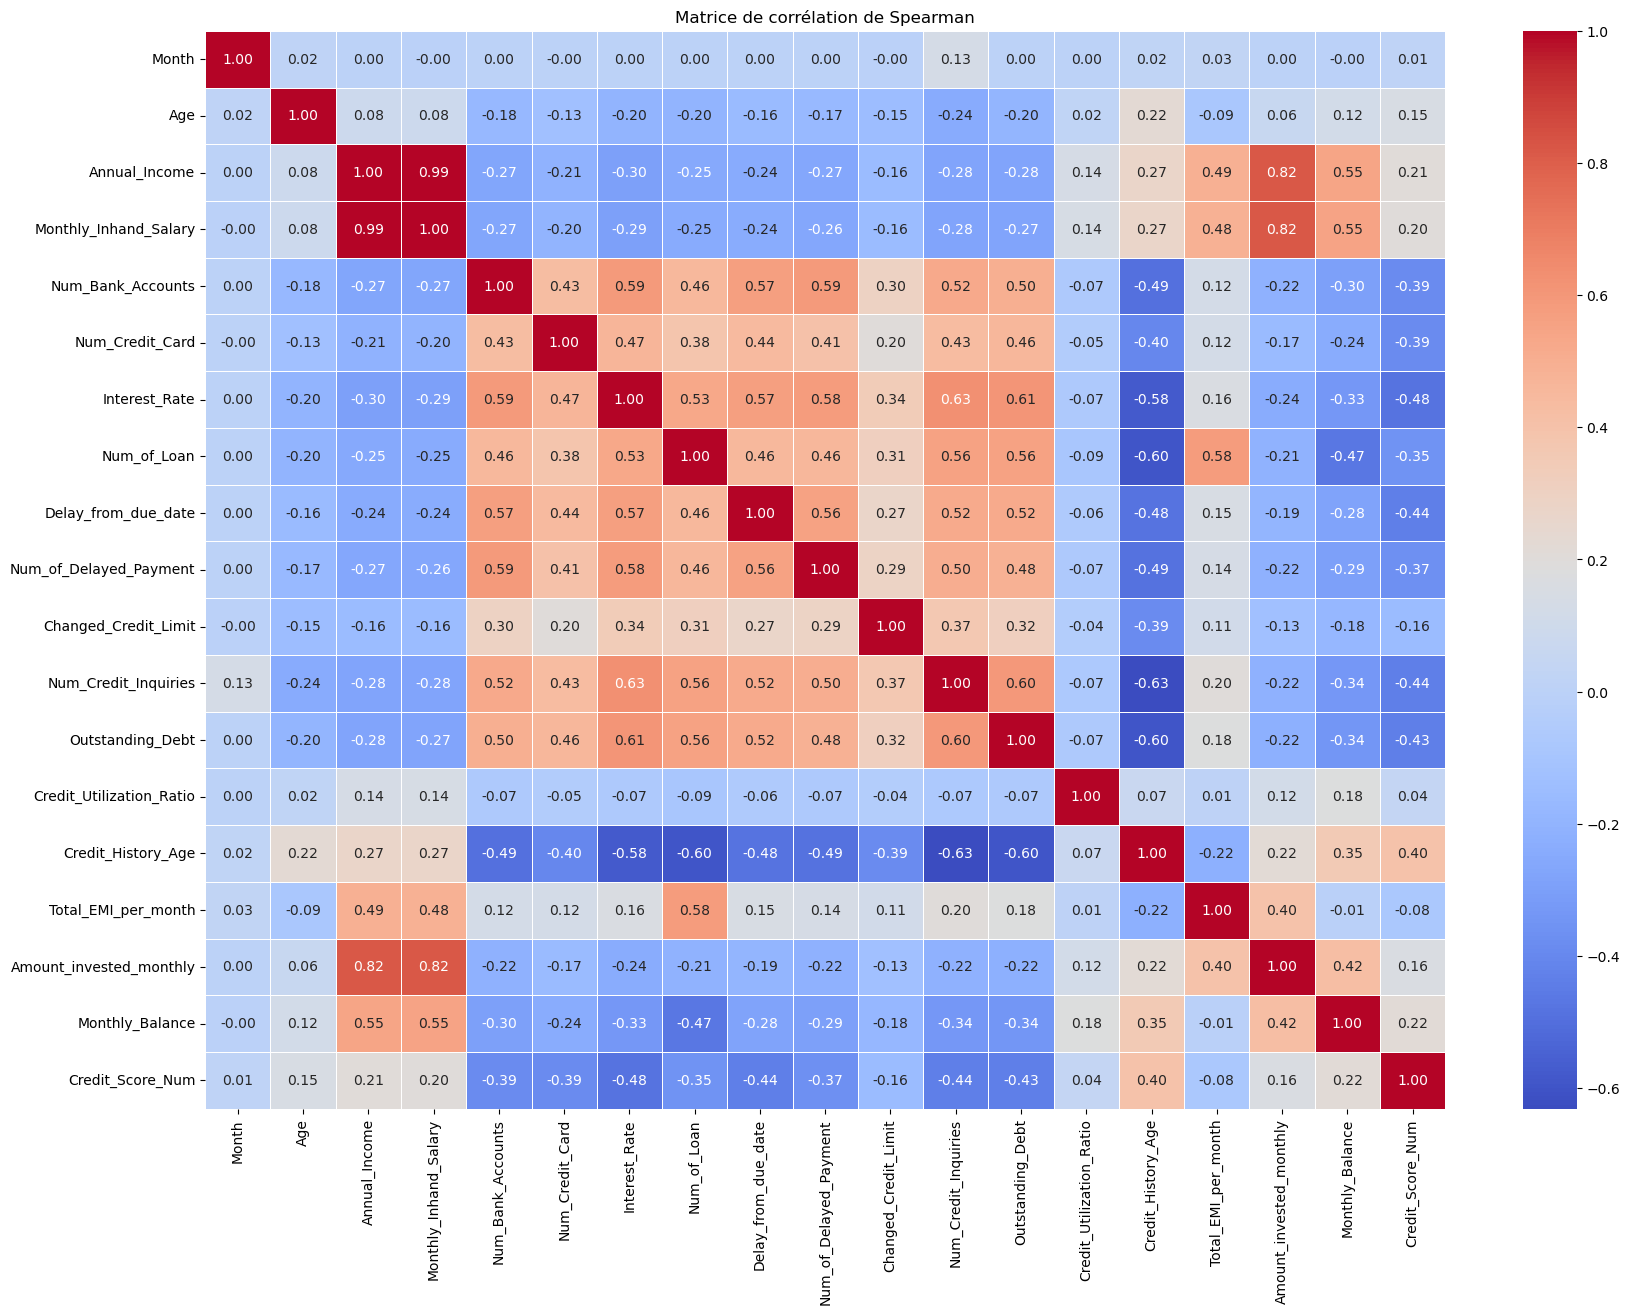

In [23]:
numeric_columns = df.select_dtypes(include="number")
correlation_matrix_spearman, _ = spearmanr(numeric_columns)

plt.figure(figsize=(20, 14))
sns.heatmap(
    correlation_matrix_spearman,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5,
    fmt=".2f",
    xticklabels=numeric_columns.columns,
    yticklabels=numeric_columns.columns,
)
plt.title("Matrice de corrélation de Spearman")
plt.show()

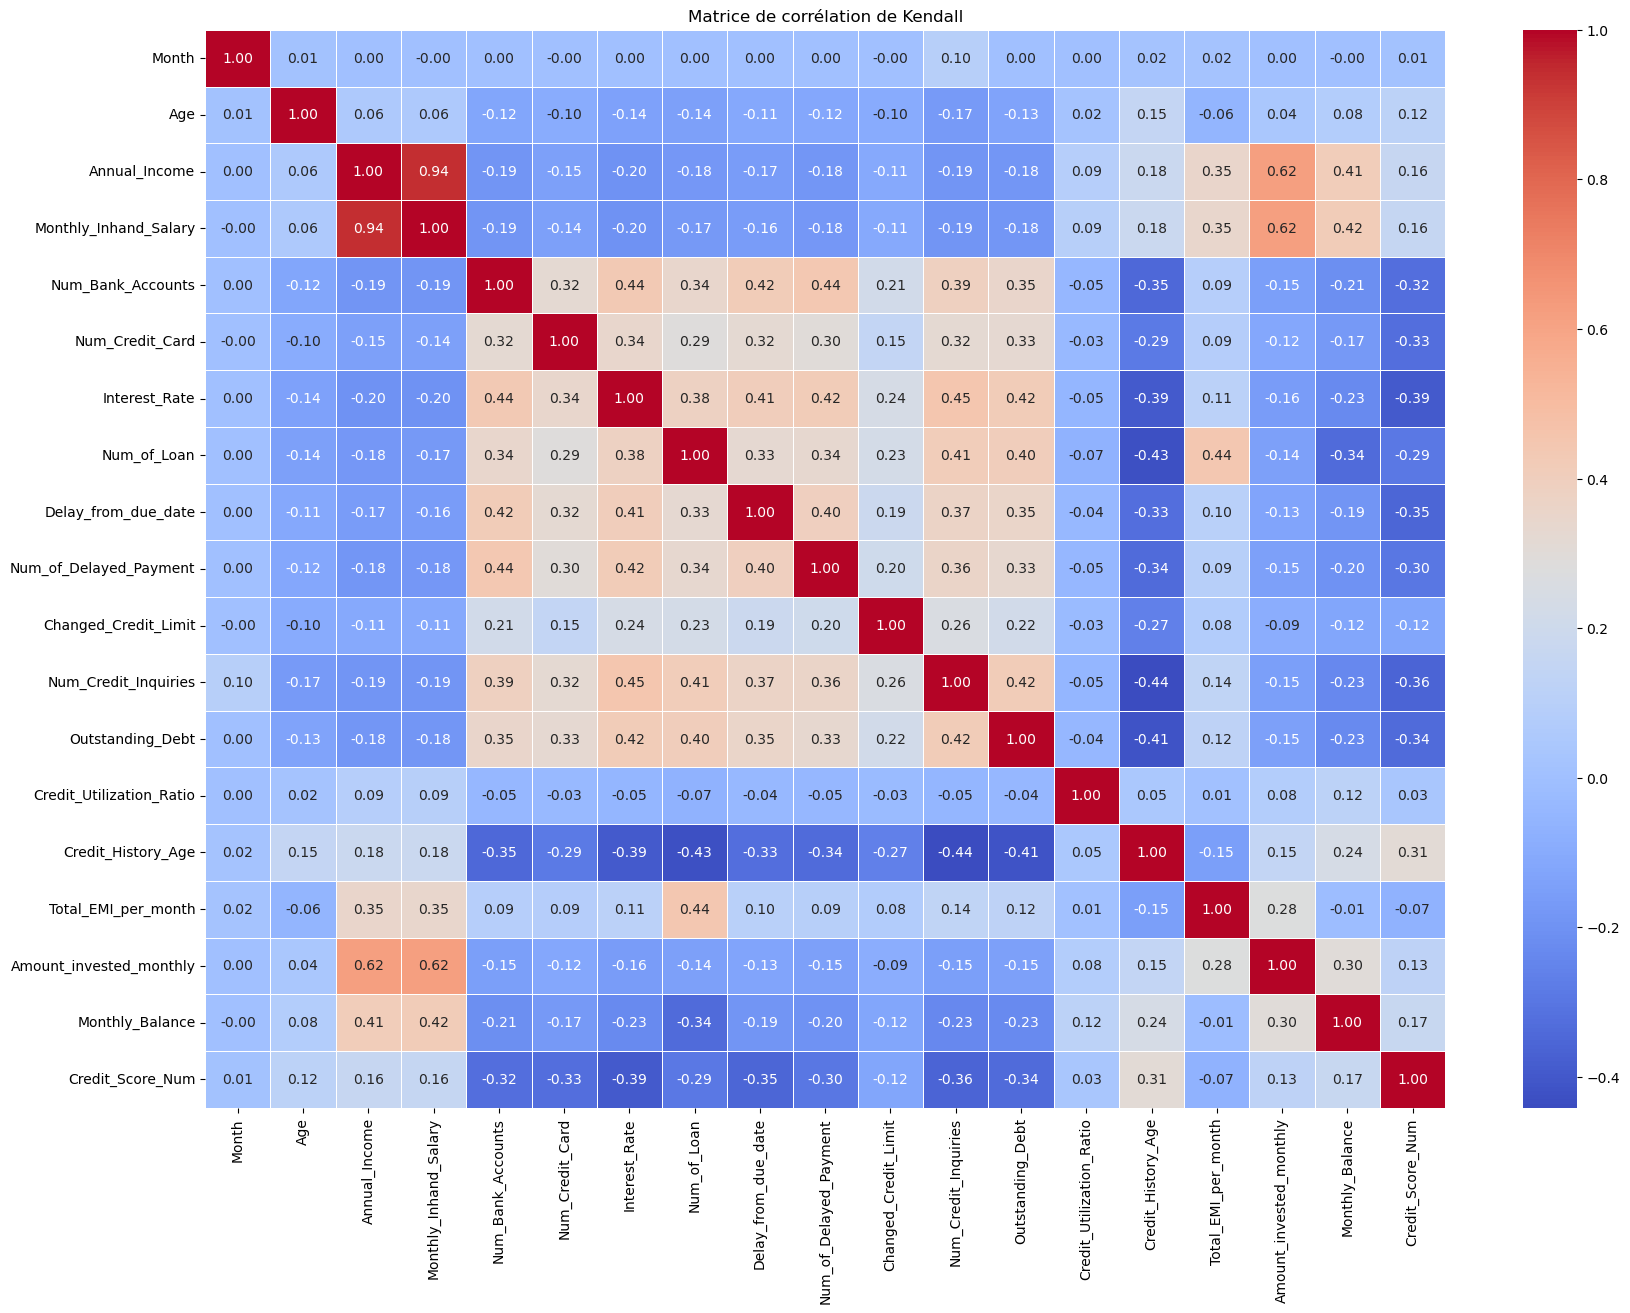

In [24]:
numeric_columns = df.select_dtypes(include="number")
correlation_matrix_kendall = numeric_columns.corr(method="kendall")

plt.figure(figsize=(20, 14))
sns.heatmap(
    correlation_matrix_kendall,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5,
    fmt=".2f",
    xticklabels=correlation_matrix_kendall.columns,
    yticklabels=correlation_matrix_kendall.columns,
)
plt.title("Matrice de corrélation de Kendall")
plt.show()


De nombreuses variables présentent des coefficients de corrélation élevés, car elles capturent essentiellement la même information. Par exemple, prenons les variables "Annual_Income" et Monthly_Inhand_Salary ; la première représente le revenu annuel de la personne tandis que la seconde le salaire mensuel en main de la personne . Nous opterons pour la variable qui donne de meilleurs résultats lors de la phase d'entraînement.
Ces deux variables sont également très liées à la variable Amount_invested_monthly,le montant mensuel investi par la personne. Cette corrélation peut s'expliquer par le fait que plus une personne gagne bien sa vie plus elle peut investir.

Les variables liées aux cartes de crédits sont également fortement liées comme Num_Credit_Inquiries qui correspond au nombre de demandes de carte de crédit effectuées par la personne et Interest_Rate, le taux d'intérêt de la carte de crédit de la personne. En effet, le nombre élevé de demandes de carte de crédit peut être perçu comme un indicateur de risque accru par les prêteurs, ce qui peut conduire à l'attribution de taux d'intérêt plus élevés sur les nouveaux comptes de crédit.

La corrélation négative entre le solde impayé de la personne et l'âge de son historique de crédit s'explique par le fait que les individus avec un historique de crédit plus long ont tendance à avoir des soldes impayés plus faibles. Cette relation découle d'une gestion financière plus prudente au fil du temps, d'une amélioration de la situation financière progressive et d'une perception réduite du risque par les prêteurs. En somme, l'expérience financière accumulée et la confiance accrue des prêteurs conduisent à une diminution des soldes impayés chez les individus ayant un historique de crédit plus étendu.

Beaucoup d'autres variables semblent corrélées les unes aux autres que ce soit négativement ou positivement. Il est intéressant de regarder une à une ces relations et cela souligne l'importance de l'analyse des corrélations dans la sélection des caractéristiques pour le modèle, en évitant la redondance et en choisissant les variables les plus informatives.

### 3. Boxplot

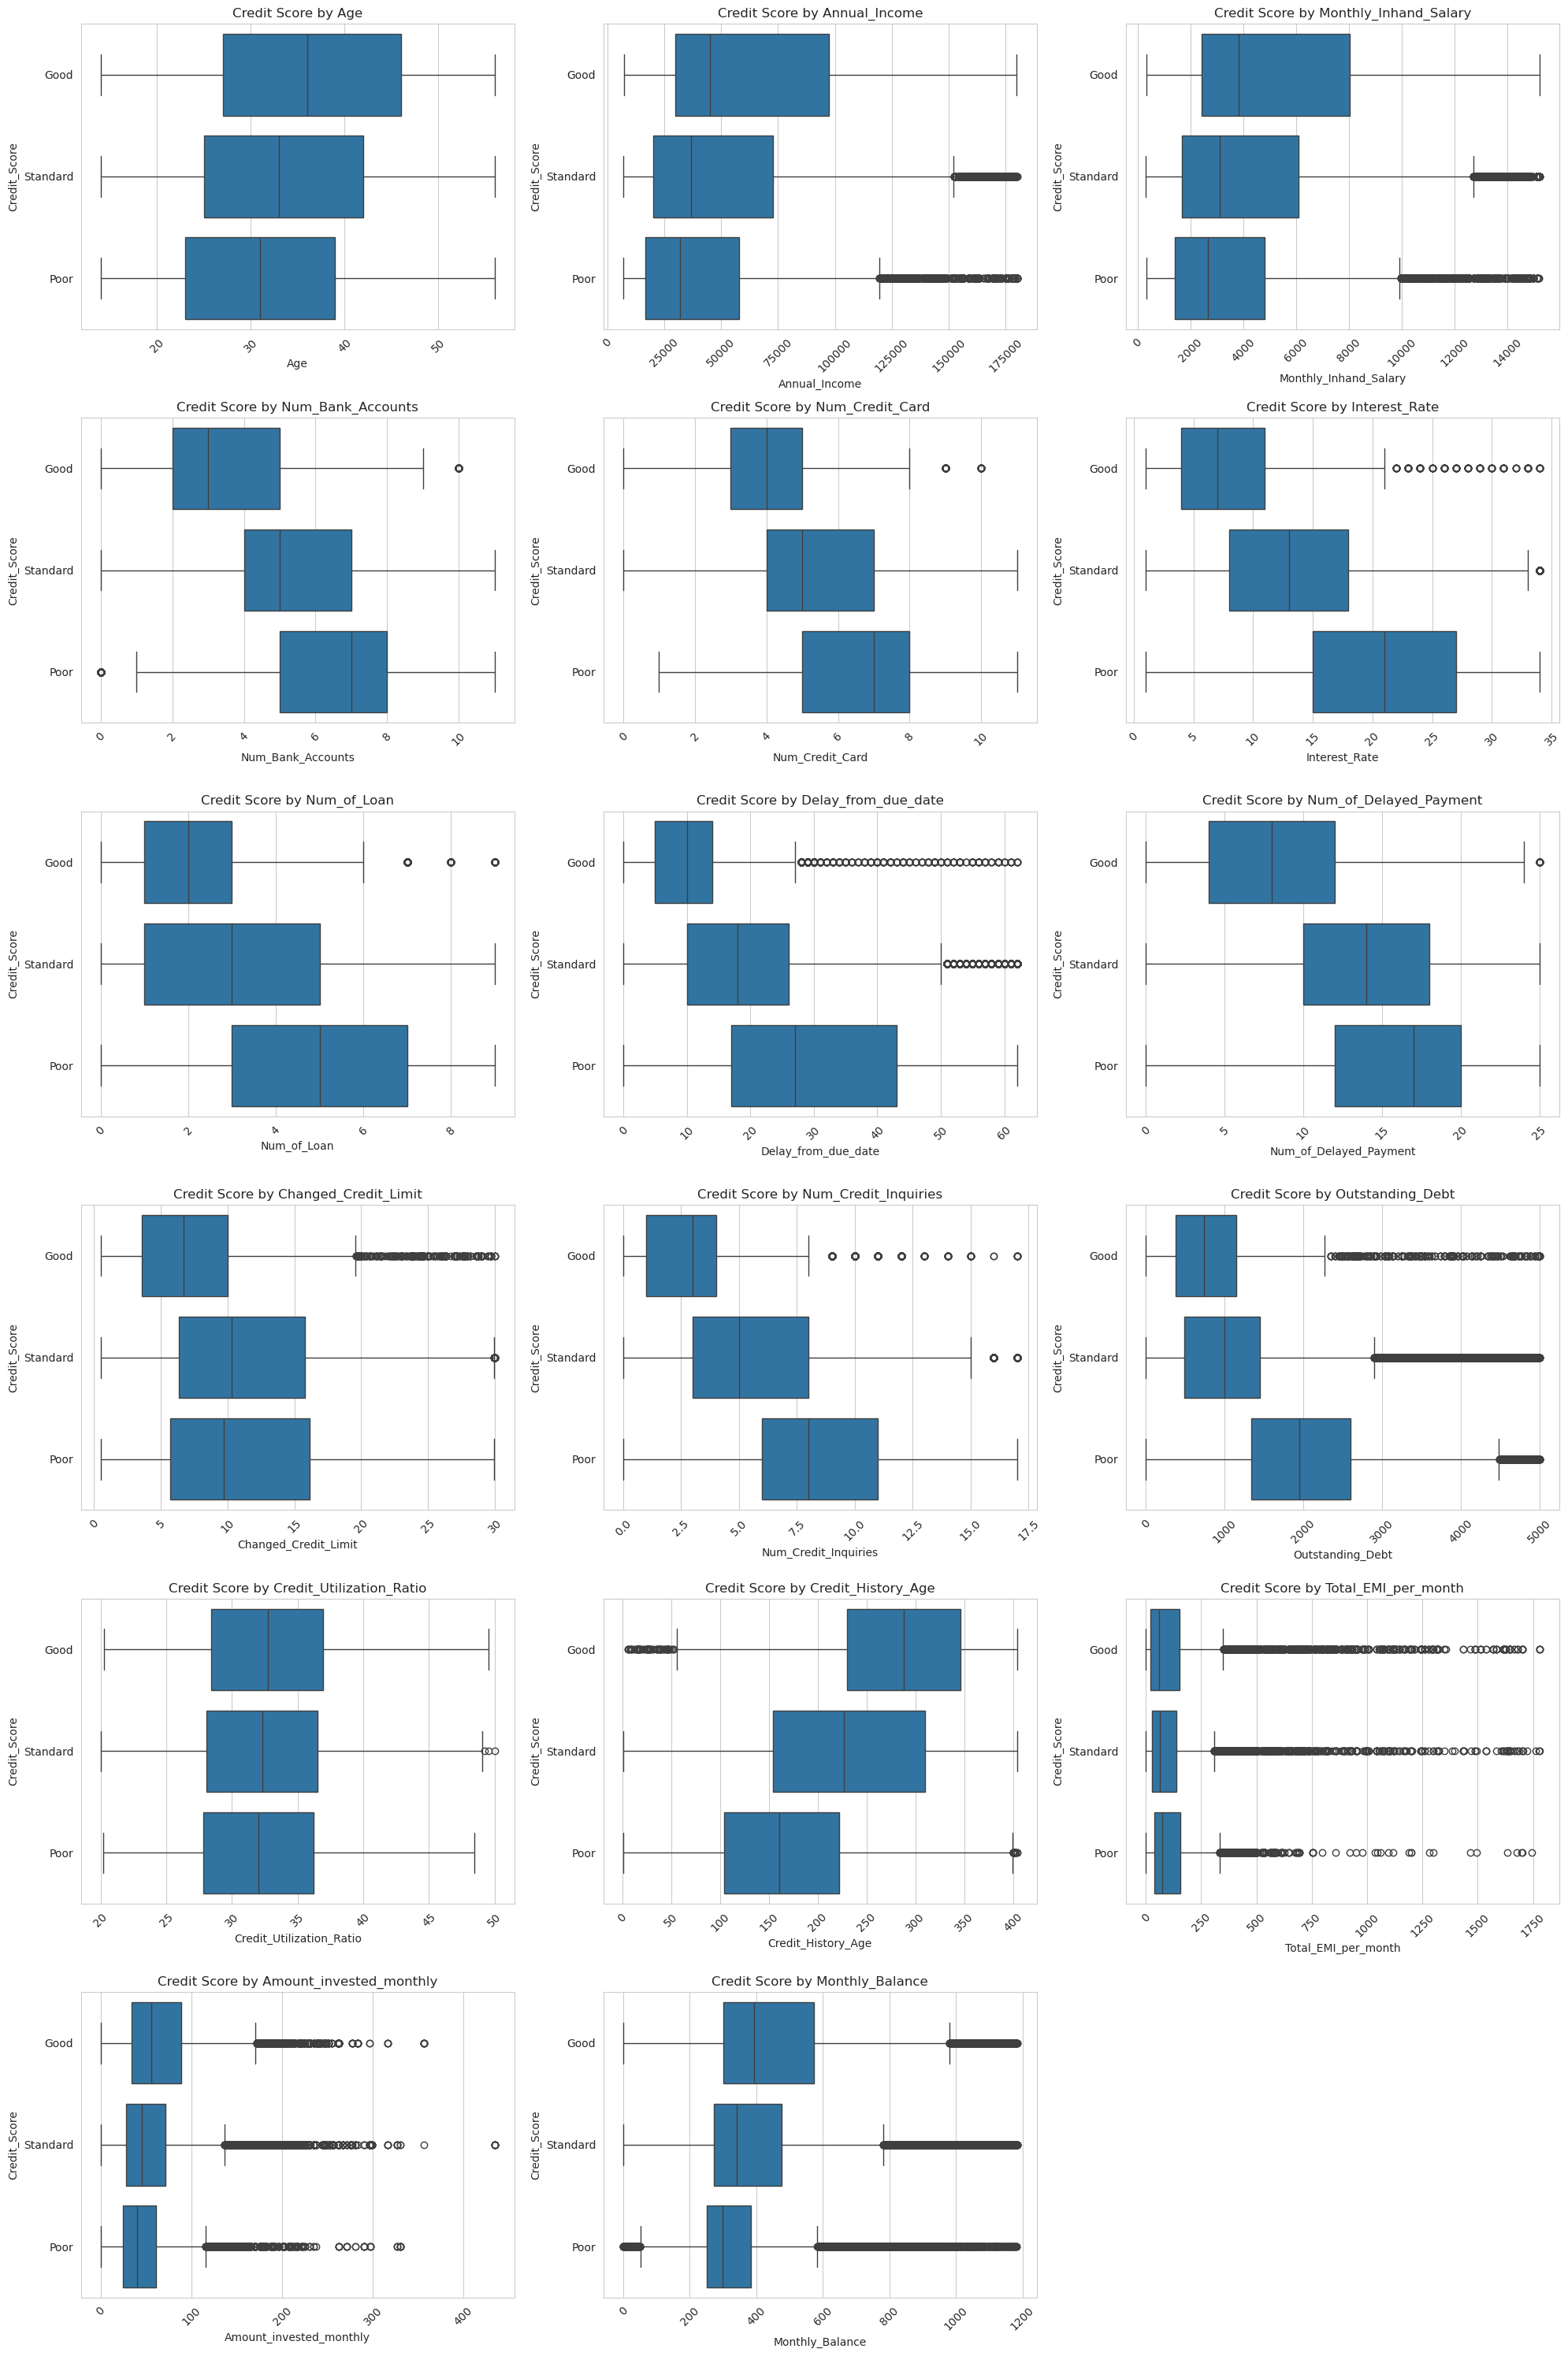

In [26]:
# boxplots
sns.set_style("whitegrid")

numerical_vars = [
    "Age",
    "Annual_Income",
    "Monthly_Inhand_Salary",
    "Num_Bank_Accounts",
    "Num_Credit_Card",
    "Interest_Rate",
    "Num_of_Loan",
    "Delay_from_due_date",
    "Num_of_Delayed_Payment",
    "Changed_Credit_Limit",
    "Num_Credit_Inquiries",
    "Outstanding_Debt",
    "Credit_Utilization_Ratio",
    "Credit_History_Age",
    "Total_EMI_per_month",
    "Amount_invested_monthly",
    "Monthly_Balance",
]

n_cols = 3
n_rows = (len(numerical_vars) + 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
plt.tight_layout(pad=5.0, h_pad=5.0, w_pad=2.0)

for i, var in enumerate(numerical_vars):
    row = i // n_cols
    col = i % n_cols
    sns.boxplot(ax=axes[row, col], x=var, y="Credit_Score", data=df)
    axes[row, col].set_title(f"Credit Score by {var}")
    for label in axes[row, col].get_xticklabels():
        label.set_rotation(45)

for i in range(len(numerical_vars), n_rows * n_cols):
    fig.delaxes(axes.flatten()[i])

fig.tight_layout()
plt.show()

### 4. Annexe

Les tests de corrélation à utiliser sont les suivants :

- Corrélation de Spearman

Hypothèses :

H0 : Il n'y a pas de corrélation *monotone* entre les deux variables.

H1 : Il y a une corrélation monotone entre les deux variables.

Conditions d'utilisation :

Les deux variables sont quantitatives ou *ordinales*.
Les données n'ont pas besoin d'être normalement distribuées.
La relation entre les variables peut être monotone (linéaire ou non linéaire).

Interprétation : Le coefficient de corrélation de Spearman varie entre -1 et 1.

Si le coefficient est proche de 1 (un seuil à 60%), il y a une corrélation positive entre les variables.
Si le coefficient est proche de -1 (un seuil à 60%), il y a une corrélation négative entre les variables.
Si le coefficient est proche de 0, il n'y a pas de *corrélation monotone (linéaire ou non linéaire) entre les variables*.

- Corrélation de Kendall

Hypothèses :

H0 : Il n'y a pas de *corrélation monotone* entre les deux variables.

H1 : Il y a une corrélation monotone entre les deux variables.

Conditions d'utilisation :

Les deux variables sont quantitatives ou ordinales.
Les données n'ont pas besoin d'être normalement distribuées.
La relation entre les variables peut être monotone (linéaire ou non linéaire).

Interprétation : Le coefficient de corrélation de Kendall varie entre -1 et 1.

Si le coefficient est proche de 1 (un seuil à 70%), il y a une corrélation positive entre les variables.
Si le coefficient est proche de -1 (un seuil à 70%), il y a une corrélation négative entre les variables.
Si le coefficient est proche de 0, il n'y a pas de corrélation monotone entre les variables

Les tests d'association à utiliser sont les suivants :

- Test de Mann-Whitney

Hypothèses

H0 : Les distributions des deux groupes sont égales.

H1 : Les distributions des deux groupes sont différentes.

Conditions d'utilisation

Les observations sont indépendantes.
Les données peuvent être ordonnées (au moins ordinale).

- Test du chi-carré (chi2)

Hypothèses

H0 (hypothèse nulle): Il n'y a pas d'association entre les deux variables qualitatives.

H1 (hypothèse alternative): Il y a une association entre les deux variables qualitatives.

Conditions d'utilisation

Les deux variables sont qualitatives (catégoriques).
Les effectifs attendus sont supérieurs à 5 pour chaque croissement de variable

- Coefficient de Cramer-V

Le coefficient de Cramér-V mesure la force de l'association entre deux variables qualitatives. Il varie entre 0 (pas d'association) et 1 (association parfaite).

Conditions d'utilisation

Les deux variables sont qualitatives (catégoriques).
Le test du chi-carré a déjà été effectué et a montré une association significative entre les deux variables.
Interprétation

Plus la valeur de Cramér-V est proche de 1 (supérieur à 0.60), plus l'association entre les deux variables est forte.